### 1. Rectifying Bias - cross validation
In the first assignment the impact of the strategies to reduce bias was assessed using
hold-out testing. The results from this assessment were unstable because of the size of the
training data - different train-test splits produce different results. Repeat this assessment
using pipelines and cross validation.

#### 1. From your first assignment submission, show the hold-out evaluation of the impact of your bias reduction strategy (just one strategy). This will serve as a base-line.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from collections import Counter

surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'

min_class = Counter(surv['Survived']).most_common()[-1][0]
#surv['Die'] = np.where(surv['Survived'] == min_class , 1 , 0)

#surv.pop('Survived')
surv.pop('Class')

y = surv.pop('Survived').values
X = surv.values

Loading the dataset and assinging values to the X and y variables

In [3]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 1/5)

#sm = SMOTE(sampling_strategy = 1.0)
#X_train_sm, y_train_sm = sm.fit_sample(X_train,y_train)

#len(y_train), len(y_train_sm)


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


Loading in the classifier classes 

In [5]:
kNN = KNeighborsClassifier(n_neighbors=3)
svm = SVC(kernel = 'linear', C = 1)
dtree = DecisionTreeClassifier(criterion='entropy')
mnb = GaussianNB()
lreg = LogisticRegression(solver = 'lbfgs')
boost = GradientBoostingClassifier()
xgb = XGBClassifier()

models = (kNN,dtree,mnb,svm,lreg,boost,xgb)



In [6]:
def bias(y_test,y_pred):
    min_class = Counter(y_test).most_common()[-1][0]
    return Counter(y_pred)[min_class]/Counter(y_test)[min_class] 


Bias can be measured in a few different ways.
For my analysis I will mainly use 
(count of minority class in predicted data)/(count of minority class in test data)

In [7]:
from sklearn.metrics import accuracy_score
sm = SMOTE(sampling_strategy = 1.0)

def simulate(num_sims,models, X , y ,smote = False, metric = 'accuracy'):
    
    if metric == 'accuracy':
        scorer = accuracy_score
    elif metric == 'bias':
        scorer = bias
    else:
        print('Error')
    vals = np.zeros((num_sims, len(models)))
    
    for i in range(num_sims):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 1/5,shuffle = True)
        if smote == True:
            X_train, y_train = sm.fit_sample(X_train,y_train)
        j = 0
        for model in models:
            y_pred = model.fit(X_train,y_train).predict(X_test)
            vals[i,j] = scorer(y_test,y_pred)
            j += 1
            
    store = pd.DataFrame(index = ['Mean','St Dev'], columns = [type(m).__name__ for m in models])
    store.loc['Mean',:] = np.mean(vals,axis = 0)
    store.loc['St Dev',:] = np.std(vals,axis = 0)
    store.sort_values(by = 'Mean', axis = 1, ascending = False, inplace = True)
    
    return store
    
    

The simulate function outputs a Pandas dataframe with the mean and standard deviation for each classifier.

You can specifiy the number of simulations you want to run with the num_sims parameter.
The higher this number, the closer to the true mean and standard deviation the outputed values will be, but the more expensive(time consuming) the process will be.

The function is based on hold out testing. 

The smote parameter determines whether to apply SMOTE (when smote = True) or not. 
By default it is set to False.

The metric parameter determines whether to calculate 'accuracy' or bias scores.
Bias is calculated using the user defined function bias defined earlier in this notebook.


Accuracy, no SMOTE, hold-out testing
       GaussianNB LogisticRegression        SVC KNeighborsClassifier  \
Mean     0.756935            0.75371   0.736935             0.711935   
St Dev  0.0481313          0.0487009  0.0455453             0.052859   

       GradientBoostingClassifier XGBClassifier DecisionTreeClassifier  
Mean                     0.707419      0.677903               0.663226  
St Dev                  0.0545066     0.0548128              0.0521285  


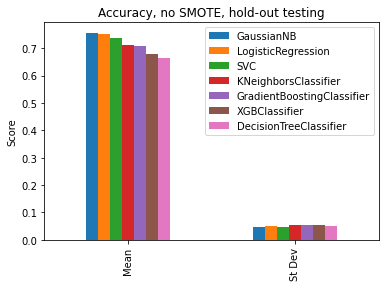

In [8]:
import matplotlib.pyplot as plt
acc_ = simulate(100,models,X,y)
def table_and_plot(df,title):
    print(title)
    print(df)
    df.plot(kind = 'bar')
    plt.title(title)
    plt.ylabel('Score')
    plt.show()
    
table_and_plot(acc_,'Accuracy, no SMOTE, hold-out testing')
    

Bias, no SMOTE, hold-out testing
       DecisionTreeClassifier XGBClassifier KNeighborsClassifier  \
Mean                  1.02855      0.913902             0.731903   
St Dev               0.358013      0.312963             0.283506   

       GradientBoostingClassifier GaussianNB LogisticRegression       SVC  
Mean                     0.717598   0.358977           0.270992  0.115894  
St Dev                   0.263311   0.182441           0.157106  0.191936  


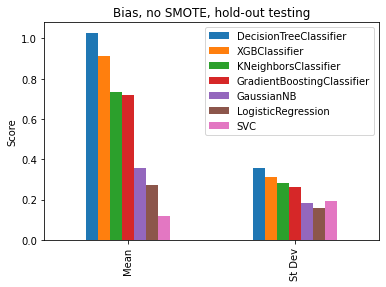

In [9]:
bias_ = simulate(100,models,X,y,metric = 'bias')
table_and_plot(bias_,'Bias, no SMOTE, hold-out testing')

Accuracy,SMOTE, hold-out testing
       GaussianNB        SVC LogisticRegression DecisionTreeClassifier  \
Mean     0.740806   0.734677           0.709355               0.634032   
St Dev  0.0553701  0.0481918          0.0555916               0.055905   

       GradientBoostingClassifier KNeighborsClassifier XGBClassifier  
Mean                      0.63129             0.630484      0.630161  
St Dev                   0.044641            0.0501867     0.0509154  


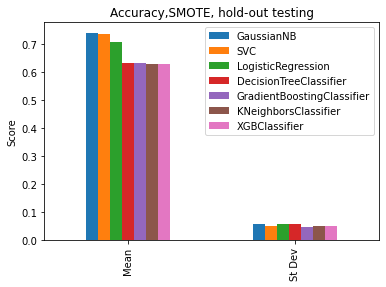

In [10]:
acc_smote = simulate(100,models,X,y,smote = True)
table_and_plot(acc_smote,'Accuracy,SMOTE, hold-out testing')

Bias,SMOTE, hold-out testing
       KNeighborsClassifier GradientBoostingClassifier XGBClassifier  \
Mean                1.39219                    1.31118       1.24698   
St Dev             0.408459                   0.374284      0.375495   

       DecisionTreeClassifier LogisticRegression       SVC GaussianNB  
Mean                  1.24095            1.10225  0.774163   0.675245  
St Dev               0.369877           0.311866  0.245258   0.220398  


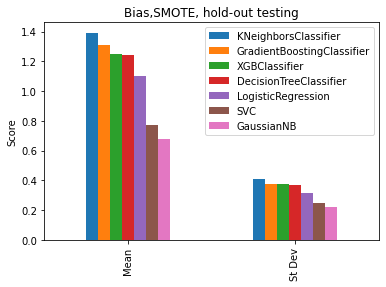

In [11]:
bias_smote = simulate(100,models,X,y,smote = True, metric = 'bias')
table_and_plot(bias_smote,'Bias,SMOTE, hold-out testing')

In [12]:
np.mean(acc_smote - acc_ , axis = 1)

Mean     -0.042465
St Dev    0.000588
dtype: float64

We can see that using SMOTE reduces accuracy by ~ 3% on average across the classifiers.
The very small average change of ~ 0.1% in St Deviation of the accuracy estimates shows SMOTE  has neglible effect on the stability of these scores for hold out testing.

In [13]:
np.mean(bias_smote - bias_ , axis = 1)

Mean      0.51502
St Dev    0.07948
dtype: float64

We can see that as a result of SMOTE, the Minority class is now almost over predicted due to the bias 
Values being > 1. We can also see that the Standard deviation of these bias values are quite high at ~6%, meaning there is high variation in the bias between runs for the classifiers.

We see the average bias across the classifiers has increased by 51 percentage points.


#### 2. Use a Pipeline to repeat this evaluation using cross validation.

In [14]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer



In [15]:
def simulate_cross_val(num_sims,models, X , y ,smote = False,metric = 'accuracy'):
    
    acc = np.zeros((num_sims, len(models)))
    bias_scores = np.zeros((num_sims, len(models)))
    
    if smote == False:
        sm = 'passthrough'
    else:
        sm  = SMOTE(sampling_strategy = 1.0)
    
    scoring = {'accuracy':'accuracy' , 'bias' : make_scorer(bias)}
    cv = KFold(n_splits = 10, shuffle = True)
    
    for i in range(num_sims):
        j = 0
        for model in models:
            model_pipe = Pipeline(steps = [
                ('sampling',sm),
                ('classifier',model)
            ])
            
            scores = cross_validate(model_pipe,X,y,scoring = scoring , cv = cv)
            acc[i,j] = np.mean(scores['test_accuracy'])
            bias_scores[i,j] = np.mean(scores['test_bias'])
            
            j += 1
            
    if metric == 'accuracy':
        vals = acc
    elif metric == 'bias':
        vals = bias_scores
    else:
        pass
    
    store = pd.DataFrame(index = ['Mean','St Dev'], columns = [type(m).__name__ for m in models])
    store.loc['Mean',:] = np.mean(vals,axis = 0)
    store.loc['St Dev',:] = np.std(vals,axis = 0)
    store.sort_values(by = 'Mean', axis = 1, ascending = False, inplace = True)
    
    return store

The simulate_cross_val function outputs the same Pandas dataframe as the simulate function.
The difference being that the simulate_cross_val function uses a pipeline(for the SMOTE transformation) and cross validation.

The pipeline enables us to use cross validation instead of hold out testing. 


Accuracy, no SMOTE, Cross Val
       GaussianNB         SVC LogisticRegression GradientBoostingClassifier  \
Mean     0.742014    0.734141           0.715148                    0.63182   
St Dev  0.0073073  0.00791152          0.0112168                  0.0166571   

       KNeighborsClassifier DecisionTreeClassifier XGBClassifier  
Mean               0.631491               0.622657      0.619373  
St Dev            0.0160985              0.0204645     0.0182607  


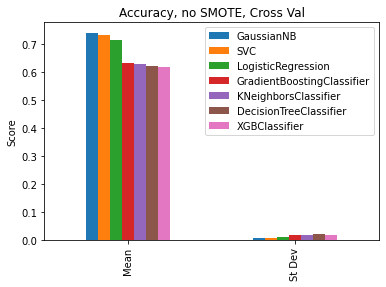

In [16]:
cross_val_acc_smote = simulate_cross_val(100,models,X,y,smote = True,metric = 'accuracy')
table_and_plot(cross_val_acc_smote,'Accuracy, no SMOTE, Cross Val')

In [17]:
np.mean(cross_val_acc_smote - acc_smote,axis = 1)

Mean     -0.002023
St Dev   -0.037555
dtype: float64

#### 3. Comment on the differences between the two evaluations. You may choose to run both evaluations multiple times to show the differences.

#### Accuracy

We can see from the results of the code above that the Cross validation method provides greater
stability in the accuracy estimates than the hold out testing.

The average difference in standard deviation for the classifier accuracy is ~3%, with the 
cross val st deviations being the lower. 

This shows that cross fold validation provides better(more stable in this case) classifiers

Theoretically, cross validation should give more stable estimates for accuracy scores and bias scores 
than hold out testing. 

This is because Cross Validation considers all cuts of the data as train and test data and gets the 
average value, while Hold out only considers one chunk as training and one as testing.

Hold out can hence lead to a 'lucky' or 'unlucky' split of the data, resulting in unstable
estimators.

Cross validaion considers every split in turn and hence is not sensitve to how the data is split,
leading to more stable estimators.

Cross validation takes longer to run than hold out testing, as for a split of 1/n we train the 
classifier n times for cross validation, but only once for hold out testing.

#### Bias

In [18]:
cross_val_bias_smote = simulate_cross_val(100,models,X,y,smote = True,metric = 'bias')
cross_val_bias_smote

,KNeighborsClassifier,GradientBoostingClassifier,DecisionTreeClassifier,XGBClassifier,LogisticRegression,SVC,GaussianNB
Mean,1.54969,1.47708,1.40664,1.3717,1.17541,0.832843,0.727243
St Dev,0.150929,0.13644,0.165276,0.111193,0.111855,0.0758908,0.0737944


In [19]:
np.mean(cross_val_bias_smote - bias_smote,axis = 1)

Mean      0.113950
St Dev   -0.211466
dtype: float64

We can see that using cross validation significantly increases the stability of the bias calculations.

The average difference in standard deviation for the classifier bias is ~20%, with the 
cross val st deviations being the lower. 

Again we see that cross validaton is better than hold out testing if we value model stability 
over computation speed.



## In preparing your submission, you should focus on explaining discrepancies between train and test performance rather than maximising performance

### 2. Feature Selection

The objective of this exercise is to assess the impact of feature selection on training and test datasets. Two datasets accompany this assignment, heart-train.csv and heart-test.csv .


The idea is to identify a good feature subset using the training dataset and test this subset on the test data. In preparing your submission, you should focus on explaining discrepancies between train and test performance rather than maximising performance.

In [20]:
import numpy as np
import pandas as pd

heart_train = pd.read_csv('heart-train.csv')
heart_test = pd.read_csv('heart-test.csv')

y_train = heart_train.pop('DEATH_EVENT')
X_train = heart_train.values

y_test = heart_test.pop('DEATH_EVENT')
X_test = heart_test.values

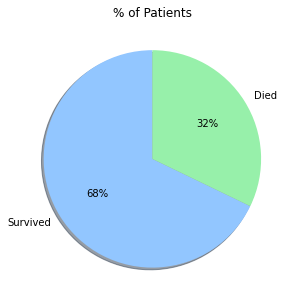

In [21]:
import matplotlib.style
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

mpl.style.use('seaborn-pastel')

fig , (ax1)  = plt.subplots(1,figsize = (10,5))

ax1.pie(y_train.value_counts(),
        labels = ['Survived','Died'],
        autopct = '%1.0f%%' ,
        shadow = True ,
        startangle = 90 )

ax1.set_title('% of Patients')

plt.savefig('pir.png',edgecolor = 'white',transparent = True)

Importing the relevant modules, then calculating the cross val and accuracy scores

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

folds = KFold(n_splits = 10, shuffle = True)

gb = GradientBoostingClassifier()

scores = cross_val_score(gb,X_train,y_train, cv = folds)
print('Cross Val Accuracy score for train data {0:.3f}'.format(np.mean(scores)))

y_pred = gb.fit(X_train, y_train).predict(X_test)
print('Hold out Accuracy score for test data {0:.3f}'.format(accuracy_score(y_test,y_pred)))


Cross Val Accuracy score for train data 0.784
Hold out Accuracy score for test data 0.820


It appears the test data predicts better than the train data.
It is possible that this is because there is less noise in the test data.

Making a pipeline, without feature Selection

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

gb_pipe = Pipeline(steps = [
    ('scaler','passthrough'),
    ('classifier',GradientBoostingClassifier())
])

param_grid = {'scaler':['passthrough',StandardScaler(),MinMaxScaler()],
              'classifier__learning_rate':[0.03,0.05,0.07,0.1,0.12],
              'classifier__n_estimators':[25,50,100,],
              'classifier__max_depth':[1,2,3,5],
             }

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(gb_pipe,param_grid,cv = folds ,verbose = 0,n_jobs = -1)
grid_search = grid_search.fit(X_train,y_train)

y_pred = grid_search.predict(X_test)
print('Accuracy score for test data {0:.3f}'.format(accuracy_score(y_test,y_pred)))

Accuracy score for test data 0.870


In [24]:
print(grid_search.best_score_)
grid_search.best_params_

0.8494736842105264


{'classifier__learning_rate': 0.07,
 'classifier__max_depth': 1,
 'classifier__n_estimators': 50,
 'scaler': 'passthrough'}

Normalized confusion matrix
[[0.94 0.06]
 [0.28 0.72]]


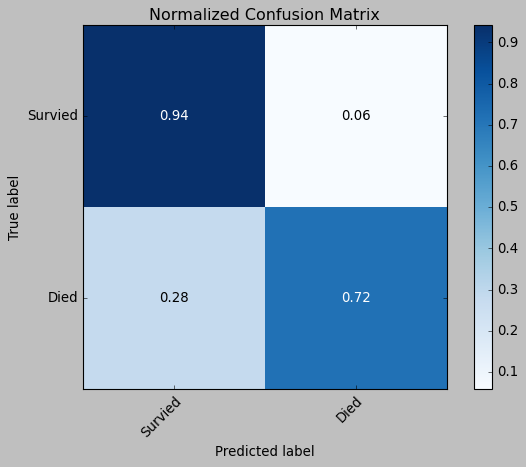

In [25]:

from sklearn.utils.multiclass import unique_labels
mpl.style.use('classic')

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=['Survied','Died'], normalize=True,
                      title='Normalized Confusion Matrix')

plt.show()

We see from the confusion matrix a high False negative rate - This means that the model is biased towards the majority class.

In order to rectify this, we will use SMOTE to upsample to reduce bias.


In [26]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

gb_pipe = Pipeline(steps = [
    ('sampling', SMOTE(sampling_strategy = 1.0)),
    ('classifier',GradientBoostingClassifier())
])

param_grid = {'classifier__learning_rate':[0.05,0.07,0.1],
              'classifier__n_estimators':[75,100,125],
              'classifier__max_depth':[1,2,3,5],
              'classifier__subsample':[0.6,0.95],
             }

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(gb_pipe,param_grid,cv = folds ,verbose = 0,n_jobs = -1)
grid_search = grid_search.fit(X_train,y_train)

y_pred = grid_search.predict(X_test)
print('Accuracy score for test data {0:.3f}'.format(accuracy_score(y_test,y_pred)))

Accuracy score for test data 0.870


Normalized confusion matrix
[[0.91 0.09]
 [0.22 0.78]]


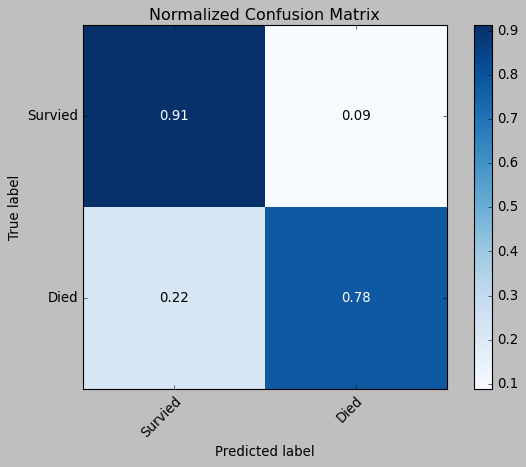

In [27]:
mpl.style.use('classic')
plot_confusion_matrix(y_test, y_pred, classes=['Survied','Died'], normalize=True,
                      title='Normalized Confusion Matrix')

plt.show()

We see an impovement in the Accuracy of the classifier, due to a reduction of false negatives.

In [28]:
print(grid_search.best_score_)
grid_search.best_params_

0.8444736842105263


{'classifier__learning_rate': 0.07,
 'classifier__max_depth': 1,
 'classifier__n_estimators': 75,
 'classifier__subsample': 0.95}

In [29]:
heart_train = pd.read_csv('heart-train.csv')
heart_test = pd.read_csv('heart-test.csv')

y_train = heart_train.pop('DEATH_EVENT')
X_train = heart_train.values

y_test = heart_test.pop('DEATH_EVENT')
X_test = heart_test.values

In [30]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
rs = 1
mi = dict()
#sm = SMOTE(sampling_strategy = 1.0)
#X_train, y_train = sm.fit_sample(X_train,y_train)

i_scores = mutual_info_classif(X_train,y_train,random_state = rs)

for i,j in zip(heart_train.columns,i_scores):
    mi[i] = j
    
df = pd.DataFrame.from_dict(mi,orient = 'index',columns = ['I-Gain'])
df.sort_values('I-Gain',ascending = False,inplace = True)

df

,I-Gain
time,0.227639
ejection_fraction,0.126230
serum_creatinine,0.092669
age,0.092031
sex,0.044166
serum_sodium,0.041860
creatinine_phosphokinase,0.015988
anaemia,0.000000
diabetes,0.000000
high_blood_pressure,0.000000


The information gain criteria shows us that time is gives the most information gain and anaemia,plaelets, sex and smoking give us the least

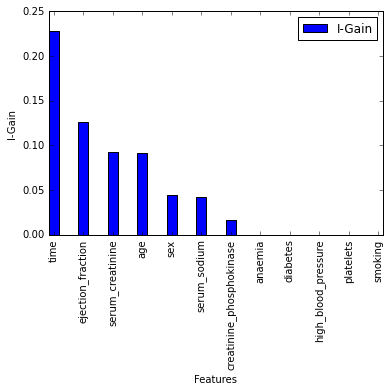

In [31]:

%matplotlib inline

n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=.35)
ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax.legend()

plt.show()

If we base the feature selection on Information Gain, we see 'time' has the highest value.

This tells us that time is an important feature to include in a feature subset that will generalize
well for this task.

After time, there is a big drop off in information gain for the other variables,
and there is another big drop after the third feature(serum creatinine).

After age, the information gain from the remaining features is very low. 
They are unlikley to be worth including as they are likely to just introduce noise into the 
classifier, which would reduce accuracy. 

The last 3 features provide 0 information gain and therefore are not expected to be useful for
a feature subset that generalizes well.

Select k best features

In [32]:
gs_params = grid_search.best_params_

kwargs = {}
for key in gs_params.keys():
    if 'classifier__' in key:

        kwargs[key.replace('classifier__','')] = gs_params[key]
        
# Change these paramters manually to see what the effect was on the accuracy of the model
        
#kwargs['n_estimators'] = 100
#kwargs['learning_rate'] = 0.07
#kwargs['max_depth'] = 2
kwargs

{'learning_rate': 0.07, 'max_depth': 1, 'n_estimators': 75, 'subsample': 0.95}

In [33]:
def mic(X,y):
    return mutual_info_classif(X,y,random_state = rs)

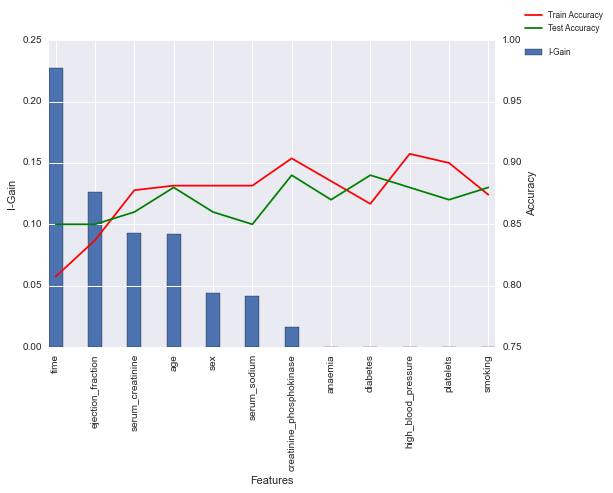

In [34]:
gb = GradientBoostingClassifier(**kwargs)

folds = KFold(n_splits = 10, shuffle = True)
train_acc_scores = []
test_acc_scores = []

for kk in range(1,X_train.shape[1]+1):
    transformer = SelectKBest(mic,k=kk).fit(X_train,y_train)
    X_train_trans = transformer.transform(X_train)
    X_test_trans = transformer.transform(X_test)
    
    sm = SMOTE(sampling_strategy = 1.0 )
    X_train_sm, y_train_sm = sm.fit_sample(X_train_trans,y_train)

    model = gb.fit(X_train_sm,y_train_sm)
    y_pred = model.predict(X_test_trans)
    
    y_pred_train = model.predict(X_train_sm)
    train_acc = accuracy_score(y_train_sm,y_pred_train)
    #train_acc = np.mean(cross_val_score(gb,X_train_trans,y_train,cv = folds,n_jobs = -1))
    train_acc_scores.append(train_acc)
    test_acc_scores.append(accuracy_score(y_test,y_pred))

df['Train Accuracy'] = train_acc_scores
df['Test Accuracy'] = test_acc_scores
  

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
mpl.style.use('seaborn')

n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots()

ax2 = ax.twinx()
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=.35)

ax2.plot(df.index, df["Train Accuracy"], color='red', label='Train Accuracy')
ax2.plot(df.index, df["Test Accuracy"], color='green', label='Test Accuracy')

ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax2.set_ylabel('Accuracy')
fontP = FontProperties()
fontP.set_size('smaller')
ax.legend( bbox_to_anchor = (1.05,1),loc = 'upper left',prop = fontP)
ax2.legend( bbox_to_anchor = (1.05,1),loc = 'lower left',prop = fontP)
ax2.set_ylim((0.75,1))

plt.show()

The code above finds the best parameters for the gradient boosting classifer within
the param_grid values, for each value of k.

The train and test accuracy are then calculated for each k and then added to the dataframe df.

The above plot shows the test(green) and train(red) accuracy for each of the feature subsets.

A feature subset of 'time', 'ejection_fraction' and 'serum_creatinine' appears to generalize
very well, giving a test accuracy score of ~89% using only 3 features, which is higher than the
train set accuracy.

If he training accuracy was higher than the testing accuracy, this would be an example of overfitting. This would mean the model has not been generalized well.

The train accuracy is considerabley higher than the testing. This could be due to the testing data containing 'clean' data with only small amounts of noise.

Features with lower information gain contain little useful information for building a classifier.
We can see from the bar chart above that anaemia, diabetes, high blood pressure, platelets and smoking provide no additional information when the features with higher information gain are included. 

We see that test data accuracy is maximized at 2 features, time and ejection_fraction,
but for train data the accuracy improves until 5 features then drops off.
This descrepancy is due to overfitting, caused by the additional features. When the model is too close of a fit to trining data, it is not useful for predicting unseen data. The small training dataset of 200 features contributes to this overfitting issue. Adding more rows of data would help rectify this.

##### Stability, Consistency
Running the above code gives quite different train/test accuracy measures. This is due to the stochastic nature of the algorithms such as the mutual info classifier and the Gradient boosting classifier.

Setting the mutual_info_classifer random state to a fixed value was important for model stability.
The features in the train data behaved in such a way to between runs, some went from having relatively high information gain to none. This impacted the stability of the model as between iterations of k this what was considered an imporant variable could change and would this would impact model stability.

The model results are also very sensitive to the parameters of the gradient boosting classifer.
Increasing n_estimators increases training data accuracy and reduces test accuracy. This is because it causes overfitting. 

max_depth controls the depth of the decision trees in the model. Setting this to higher than 1 increased train accuracy and reduced test accuracy.

Setting learning rate to more than 0.7 had the effect of making very strong overfitting. 

The model stability was greatly influnce by max_depth, increasing this more than 1 dramatically increased train accuracy and reduced test accuracy.

There are other hyper paamters in this model that also would likely have an effect on the train and test accuracy but I do not go into them in this report.

In [46]:
num_sims = 1000
acc_scores_fs = []
for i in range(num_sims):

    kk = 3
    transformer = SelectKBest(mic,k=kk).fit(X_train,y_train)
    X_train_trans = transformer.transform(X_train)
    X_test_trans = transformer.transform(X_test)

    sm = SMOTE(sampling_strategy = 1.0 )
    X_train_sm, y_train_sm = sm.fit_sample(X_train_trans,y_train)

    model = gb.fit(X_train_sm,y_train_sm)
    y_pred = model.predict(X_test_trans)

    acc_scores_fs.append(accuracy_score(y_test,y_pred)) # testing the accruacy of the chosen feature subset

In [51]:
print('Mean Test Accuracy {0:.2f}'.format(np.mean(acc_scores_fs)))
print('Test Accuracy St Dev {0:.2f}'.format(np.std(acc_scores_fs)))



Mean Test Accuracy 0.86
Test Accuracy St Dev 0.01


We see from the standard deviation of 1% and the kernel density plot that the model is relatively 
stable in its accuracy.




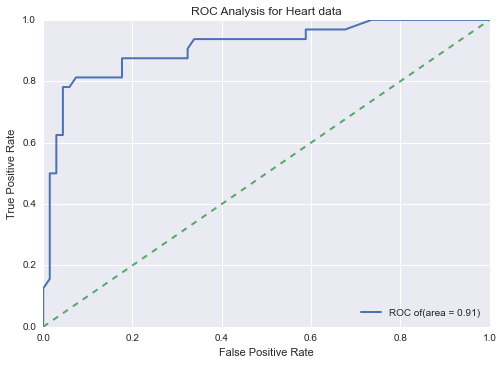

In [37]:
from sklearn.metrics import roc_curve, auc

y_score = model.predict_proba(X_test_trans) # Propabilities for the ROC Curve
fpr, tpr, t = roc_curve(y_test, y_score[:,1])
lw = 2
plt.plot(fpr, tpr,
         lw=lw, label= 'ROC of(area = %0.2f)' % auc(fpr, tpr))


plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis for Heart data')
plt.legend(loc="lower right")
plt.show()
        

Evaluating the ROC Curve of for the test data shows the model provides a good fit for the data. 
The optimal value of 1 for the ROC area under the curve is not too far from the value of 0.9 obtained.



Conclusion:
The Gradient Boosting Classifer provides a high level of accuracy when coupeld with a feature subset
selection strategy based on information gain.

A possible way of improving this model could be by using a wrapper strategy instead of information gain or using a different criteria
than information gain such as chi squared.

